# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>План исследования<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Обьявление-функций" data-toc-modified-id="Обьявление-функций-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обьявление функций</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследуем-данные" data-toc-modified-id="Исследуем-данные-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Исследуем данные</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Предобработка текста</a></span></li><li><span><a href="#Частотный-анализ-текста-и-облако-слов" data-toc-modified-id="Частотный-анализ-текста-и-облако-слов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Частотный анализ текста и облако слов</a></span></li><li><span><a href="#Подготовка-данных-для-моделей" data-toc-modified-id="Подготовка-данных-для-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подготовка данных для моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#DummyClassifier" data-toc-modified-id="DummyClassifier-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span><strong>DummyClassifier</strong></a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span><strong>LogisticRegression</strong></a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span><strong>BERT</strong></a></span></li></ul></li><li><span><a href="#Оценка-качества-модели" data-toc-modified-id="Оценка-качества-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Оценка качества модели</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Импорт библиотек

In [1]:
# Установка необходимых библиотек
!pip install --upgrade scikit-learn
!pip install transformers
!pip install nltk
!pip install wordcloud
!pip install Pillow
!pip install pandarallel


# Импорт библиотек
import random
import re
import time
import warnings

import numpy as np
import nltk
import pandas as pd
import torch
from collections import Counter
from matplotlib import pyplot as plt
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AdamW, BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from pandarallel import pandarallel


# Инициализация pandarallel
pandarallel.initialize(progress_bar=True)

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

RANDOM_STATE = 42


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Pheonix\AppData\Roaming\nltk_data...
[nltk_data]   Package

### Обьявление функций

In [2]:
# Объявление функций
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def preprocess_text(text):
    import re  
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



def lemmatize_text(text):
    import nltk
    from nltk import pos_tag, word_tokenize
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(word):
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
        }
        return tag_dict.get(tag, wordnet.NOUN)
    
    words = word_tokenize(text)
    lem_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lem_words)

def remove_stopwords(text):
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def tokenize_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Токенизация данных"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels.values)
    
    return input_ids, attention_masks, labels

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()


### Загрузка данных

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv')
except FileNotFoundError:
    try:
        df = pd.read_csv('/datasets/toxic_comments.csv')
    except FileNotFoundError:
        print("Файл не найден.")
# Первичный осмотр данных
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


### Исследуем данные

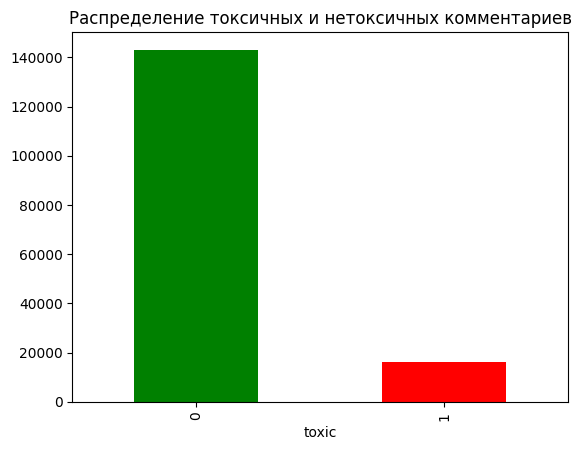

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


In [4]:
# Проверим распределение целевого признака
df['toxic'].value_counts().plot(kind='bar', color=['green', 'red'], title='Распределение токсичных и нетоксичных комментариев')
plt.show()

# Выводим статистику по длине комментариев
df['text_length'] = df['text'].apply(len)
print(df['text_length'].describe())


- Данные содержат 159292 записей с двумя столбцами: text и toxic.
- Целевой признак toxic сбалансирован неравномерно: значительно больше нетоксичных комментариев.
Длина комментариев варьируется от нескольких символов до 5000+ символов.

## Обучение

### Предобработка текста

Для подготовки текста к обучению модели предобработаем текст - избавимся от лишних символов и выполним демматизацию.

In [5]:
# Предобработка текста с использованием pandarallel
df['clean_text'] = df['text'].parallel_apply(preprocess_text)
df['clean_text'] = df['clean_text'].parallel_apply(lemmatize_text)
df['clean_text'] = df['clean_text'].parallel_apply(remove_stopwords)

# Проверим результаты
df[['text', 'clean_text']].head()

,text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really try edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestion improvement wonder s...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


Предобработанные данные готовы для обучения моделей. Удалены все лишние символы, и текст приведен в единый формат.

### Частотный анализ текста и облако слов

После предобработки данных выполним частотный анализ слов и построим облако слов для токсичных и нетоксичных комментариев. Это поможет визуально оценить наиболее часто встречающиеся слова в каждой категории и лучше понять тематику комментариев.


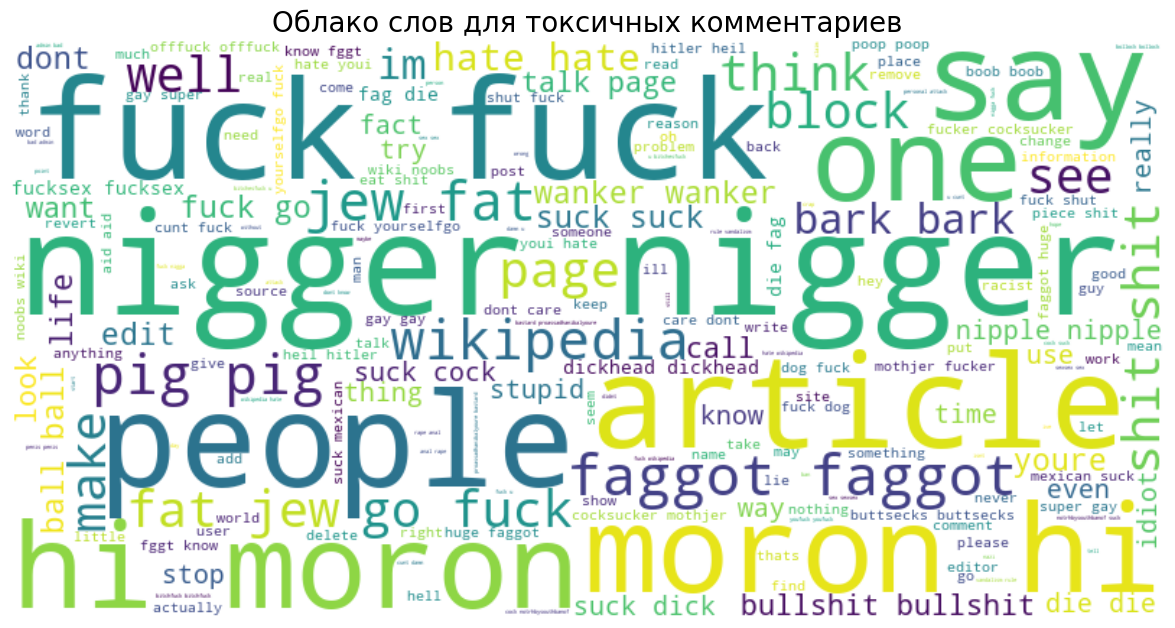

In [6]:
# Объединение текста для токсичных и нетоксичных комментариев
toxic_text = ' '.join(df[df['toxic'] == 1]['clean_text'])
non_toxic_text = ' '.join(df[df['toxic'] == 0]['clean_text'])

# Частотный анализ
toxic_words = Counter(toxic_text.split()).most_common(20)
non_toxic_words = Counter(non_toxic_text.split()).most_common(20)


# Построение облака слов
generate_wordcloud(toxic_text, "Облако слов для токсичных комментариев")

Видно, что в токсичных комментариях основной акцент на личные оскорбления и негативные высказывания. Самые популярные слова - это оскарбления. Так же очень популярны People, article, wikipedia.

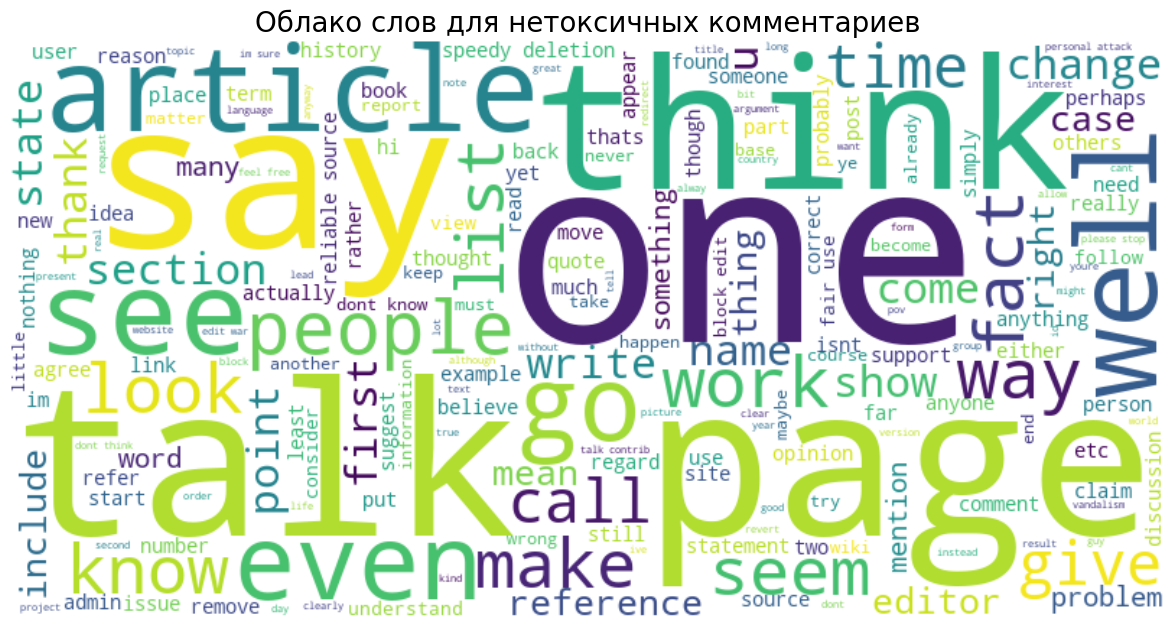

In [7]:
generate_wordcloud(non_toxic_text, "Облако слов для нетоксичных комментариев")

В нетоксичных комментариях акцент на обсуждениях и размышлениях. 

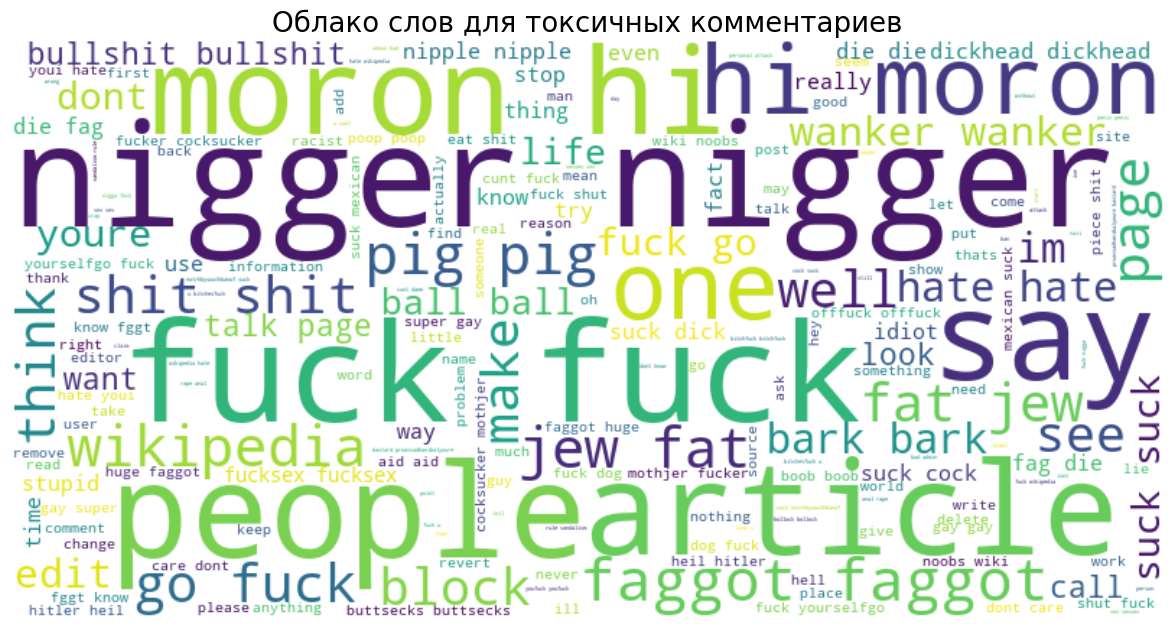

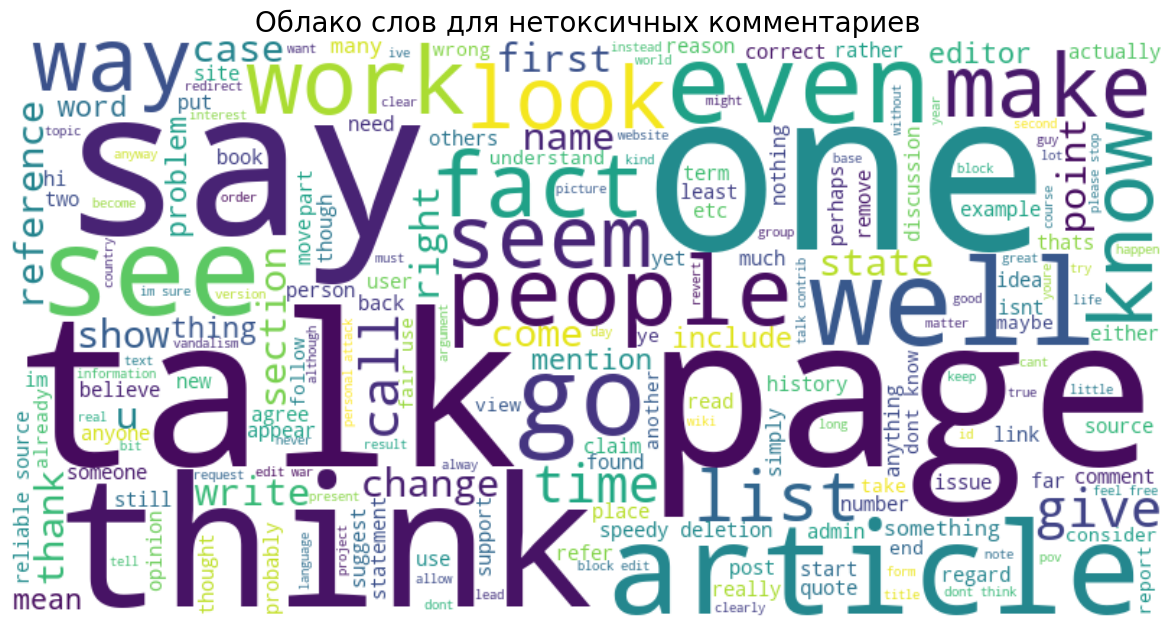

In [9]:
# Объединение текста для токсичных и нетоксичных комментариев
toxic_text = ' '.join(df[df['toxic'] == 1]['clean_text'])
non_toxic_text = ' '.join(df[df['toxic'] == 0]['clean_text'])

# Частотный анализ
toxic_words = Counter(toxic_text.split()).most_common(20)
non_toxic_words = Counter(non_toxic_text.split()).most_common(20)

# Построение облака слов
generate_wordcloud(toxic_text, "Облако слов для токсичных комментариев")
generate_wordcloud(non_toxic_text, "Облако слов для нетоксичных комментариев")

### Подготовка данных для моделей

Разделим даннык на обучающую и тестовую выборки.

In [10]:
X = df['clean_text']
y = df['toxic']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state = RANDOM_STATE)  # 0.25 x 0.8 = 0.2

print(f"Размеры обучающей выборки: {X_train.shape}, {y_train.shape}")
print(f"Размеры валидационной выборки: {X_valid.shape}, {y_valid.shape}")
print(f"Размеры тестовой выборки: {X_test.shape}, {y_test.shape}")


Размеры обучающей выборки: (95574,), (95574,)
Размеры валидационной выборки: (31859,), (31859,)
Размеры тестовой выборки: (31859,), (31859,)


### Обучение моделей

Мы будем использовать следующие модели для классификации комментариев:

- **DummyClassifier** — базовая модель для оценки
- **LogisticRegression** — логистическая регрессия с TF-IDF векторизацией
- **BERT** — передовая модель трансформеров для обработки естественного языка

Используем TfidfVectorizer для преобразования текста в векторы признаков.

In [11]:
# Векторизация текста
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### **DummyClassifier**

In [12]:
# Обучение DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_tfidf, y_train)

# Предсказания и оценка
y_pred_dummy = dummy_clf.predict(X_valid_tfidf)
print(f"F1-мера DummyClassifier: {f1_score(y_valid, y_pred_dummy):.2f}")


F1-мера DummyClassifier: 0.00


Базовая модель ожидаемо получила F1-меру = 0.00. 

#### **LogisticRegression**

Учтем дисбаланс классов и подберем гиперпараметры для **логистической регрессии** с помощью GridSearchCV.

In [13]:

# Определение диапазона значений для гиперпараметра C
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Создание экземпляра LogisticRegression с учетом дисбаланса классов
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')

# Определение метрики для GridSearch
f1_scorer = make_scorer(f1_score)

# Создание GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,  # 5-кратная кросс-валидация
    n_jobs=-1,  # Использовать все доступные ядра
    verbose=1
)

# Обучение GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Вывод наилучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая F1-метрика: {grid_search.best_score_:.2f}")

# Использование лучшей модели для предсказаний
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_valid_tfidf)

# Оценка модели
f1_lr = f1_score(y_valid, y_pred_lr)
print(f"F1-мера LogisticRegression после подбора гиперпараметра: {f1_lr:.2f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'C': 10}
Лучшая F1-метрика: 0.75
F1-мера LogisticRegression после подбора гиперпараметра: 0.76


Модель **логистической регрессии** показала F1-меру на валидационнай выборке  **0.76** что выше порога успеха.

#### **BERT**

Для обучениия **BERT** токенизируем данные.

In [19]:
# Проверка наличия GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')

config = AutoConfig.from_pretrained(
    'unitary/unbiased-toxic-roberta',
    num_labels=2,
    problem_type='single_label_classification'
)

tokenizer = AutoTokenizer.from_pretrained('unitary/unbiased-toxic-roberta')
model_bert = AutoModelForSequenceClassification.from_pretrained(
    'unitary/unbiased-toxic-roberta',
    config=config,
    ignore_mismatched_sizes=True  # Allows resizing the classifier layer
)
# Перенос модели на устройство
model_bert.to(device)


# Токенизация данных 
X_train_inputs, X_train_masks, y_train_labels = tokenize_data(X_train, y_train)
X_valid_inputs, X_valid_masks, y_valid_labels = tokenize_data(X_valid, y_valid)
X_test_inputs, X_test_masks, y_test_labels = tokenize_data(X_test, y_test)

Устройство: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([16, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([16]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Токенизация данных:   0%|          | 0/95574 [00:00<?, ?it/s]

Токенизация данных:   0%|          | 0/31859 [00:00<?, ?it/s]

Токенизация данных:   0%|          | 0/31859 [00:00<?, ?it/s]

In [20]:
# Создание DataLoader-ов
batch_size = 16

train_data = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(X_valid_inputs, X_valid_masks, y_valid_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [21]:
# Определение оптимизатора и планировщика обучения
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)

epochs = 2
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [22]:

# Обучение модели BERT
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

training_stats = []

for epoch_i in range(0, epochs):
    print(f'Эпоха {epoch_i + 1}/{epochs}')
    
    # Обучение
    model_bert.train()
    total_loss = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), desc=f"Обучение эпоха {epoch_i + 1}/{epochs}", total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model_bert.zero_grad()
        
        outputs = model_bert(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Валидация
    model_bert.eval()
    eval_accuracy = 0
    nb_eval_steps = 0
    
    true_labels = []
    predictions = []
    
    for batch in tqdm(validation_dataloader, desc="Валидация"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model_bert(
                b_input_ids,
                attention_mask=b_input_mask
            )
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Собираем предсказания и метки
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)
        
        # Рассчитываем точность на текущем батче
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    # Преобразуем списки с метками и предсказаниями в один массив
    true_labels = np.concatenate(true_labels, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    
    # Рассчитываем F1-метрику
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    avg_val_accuracy = eval_accuracy / nb_eval_steps
    print(f"Средняя точность на валидации: {avg_val_accuracy:.2f}")
    print(f"F1-метрика на валидации: {f1:.2f}")
    
    training_stats.append({
        'epoch': epoch_i + 1, 
        'Training Loss': avg_train_loss, 
        'Validation Acc': avg_val_accuracy,
        'F1 Score': f1
    })

Эпоха 1/2


Обучение эпоха 1/2:   0%|          | 0/5974 [00:00<?, ?it/s]

Валидация:   0%|          | 0/1992 [00:00<?, ?it/s]

Средняя точность на валидации: 0.96
F1-метрика на валидации: 0.96
Эпоха 2/2


Обучение эпоха 2/2:   0%|          | 0/5974 [00:00<?, ?it/s]

Валидация:   0%|          | 0/1992 [00:00<?, ?it/s]

Средняя точность на валидации: 0.96
F1-метрика на валидации: 0.96


In [24]:
print(f"Number of labels: {model_bert.config.num_labels}")
print(f"Problem type: {model_bert.config.problem_type}")


Number of labels: 2
Problem type: single_label_classification


Модель **BERT** продемонстрировала наилучшие результаты среди всех рассмотренных моделей на валидационной выборке. 

### Оценка качества модели

Оценим качество **BERT** на тестовой выборке

In [23]:
# Оценка модели BERT на тестовой выборке
test_data = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model_bert.eval()
predictions, true_labels = [], []

for batch in tqdm(test_dataloader, desc="Оценка на тестовых данных"):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Оценка BERT
print("BERT:")
print(f"F1-мера: {f1_score(true_labels, predictions):.2f}")
print(classification_report(true_labels, predictions))


Оценка на тестовых данных:   0%|          | 0/1992 [00:00<?, ?it/s]

BERT:
F1-мера: 0.82
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28658
           1       0.85      0.79      0.82      3201

    accuracy                           0.96     31859
   macro avg       0.91      0.89      0.90     31859
weighted avg       0.96      0.96      0.96     31859



Модель **BERT** показала отличные результаты на тестовой выборке с  F1-мерой **0.82**, что выше порогового значения **0.75**.

Таким образом, модель **BERT** успешно справляется с задачей классификации токсичных комментариев, значительно превосходя базовые модели, такие как **логистическая регрессия** и **DummyClassifier**, и удовлетворяет требованиям по метрике качества F1.


## Общий вывод

В ходе выполнения проекта по классификации токсичных комментариев для интернет-магазина «Викишоп» было выполнено:

1. **Подготовка данных:**

    - 1.1 **Загрузка и исследование данных:**
    - Мы загрузили и проанализировали датасет с комментариями, содержащий 159292 записи с двумя основными столбцами: `text` (текст комментария) и `toxic` (целевой признак токсичности). Выявлено, что датасет несбалансирован — подавляющее большинство комментариев нетоксичны, что требовало специальных подходов при обучении моделей.
        - Также были изучены статистические характеристики текста: средняя длина комментария составляла 394 символа, с вариациями от 5 до 5000 символов.

    - 1.2 **Очистка и предобработка текста:**
        - Все комментарии были приведены к нижнему регистру.
        - Удалены лишние элементы, такие как ссылки, знаки препинания и спецсимволы.
        - Для каждого комментария была проведена лемматизация с использованием библиотеки NLTK, что позволило привести слова к их базовой форме. Это шаг необходим для унификации текстов и повышения эффективности обработки.
        - В результате предобработки текст стал более чистым и готовым для дальнейшего обучения моделей.

    - 1.3 **Разделение данных на выборки:**
    - Датасет был разделён на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки. Такое разделение обеспечило наличие данных для обучения, подбора гиперпараметров и финальной оценки модели на тесте.

2. **Обучение моделей:**

    - 2.1 **Базовая модель (DummyClassifier):**
        - В качестве первой, базовой модели был использован **DummyClassifier**, которая выполняет предсказания, основываясь на самых частых значениях целевого признака.
        - Ожидаемо, базовая модель показала F1-меру 0.00 на валидационной выборке, так как она всегда предсказывала нетоксичные комментарии.

    - 2.2 **Логистическая регрессия с TF-IDF:**
        - Далее мы использовали **Логистическую регрессию** с преобразованием текстов в векторы признаков с помощью метода **TF-IDF**.
        - Модель была обучена c учетом дисбаланса классов. С помощью **GridSearchCV** были подобраны гиперпараметры.
        - Модель показала **0.76** на валидационной выборке, что выше необходимого порога в **0.75** на тестовой выборке.

    - 2.3 **Модель BERT:**
        - Ключевым шагом проекта стало использование передовой трансформерной модели **BERT** (Bidirectional Encoder Representations from Transformers), которая была предобучена на большом количестве текстов и затем дообучена на нашем датасете.
        - Для работы с **BERT** комментарии были токенизированы с использованием предобученного токенизатора, а данные преобразованы в формат, подходящий для обучения нейросети (включая маски внимания и идентификаторы токенов).
        - Модель была обучена на тренировочных данных, и результаты на валидационной выборке показали F1-меру 0.82, что существенно превысило целевое значение.

    - 2.4 **Оценка качества модели на тестовой выборке:**
        - Для финальной оценки модель **BERT** была протестирована на тестовой выборке. Она показала F1-меру 0.82, что свидетельствует о высоком качестве работы модели по классификации токсичных комментариев.

**Заключение:**

Модель **BERT** продемонстрировала наивысшие показатели качества среди всех моделей, применённых в проекте. Она успешно решает задачу классификации токсичных комментариев, что позволяет интернет-магазину «Викишоп» автоматически выявлять негативные комментарии и направлять их на модерацию. Проект завершен с достижением цели — F1 ≥ 0.75, и модель может быть внедрена для автоматической модерации пользовательских отзывов и комментариев.